https://github.com/TrevorChartier/AvalancheAnalysis.git

In [38]:
import pandas as pd
import numpy as np
from dateutil import parser
import plotly.express as px
import matplotlib.pyplot as plt

# CAIC Avalanche Data Analysis
This section was completeted by Trevor Chartier and Jackson Patrick. 

Author tags can be found at the top of each cell to determine who did what.

## Introduction
Trevor Chartier

The purpose of Section I of our analysis is to investigate the trends of avalanche frequencies in CO acrosss time, geographic features, and area. Our first goal is to identify any trends in avalanche frequencies over time. We then aim to find out what kinds of geographic features make for dangerous avalanche conditions, and what parts of CO are especially prone to avalances. 

Finally, in Part II (SNOTEL Data Analysis), we choose weather stations from the avalanche prone regions we identified and try to explain the trends in avalanche frequencies over time with the trends in weather patterns over time. 

In other words, are there trends in weather patterns that are impacting the formation of geographic features correlated with high avalanche dangers?

In Section I, we utilize publicly available data from CAIC that can be generated here: https://avalanche.state.co.us/observations/avalanches. It takes quite some time to generate this data for the last 14 years, so we have included the file CO_Snotel_Data that should be located within the working directory prior to running this notebook.

## Data Pre-Processing


Completed by Jackson Patrick and Trevor Chartier — see author tags

#### Reading In Data

In [39]:
avalanches_data = pd.read_csv("avalanche-record-CAIC.csv")
avalanches_data.head(3)

Observation ID                                               Date  \
0              -   Thu Apr 11 2024 12:00:00 GMT-0600 (Mountain D...   
1              -   Thu Apr 11 2024 00:12:12 GMT-0600 (Mountain D...   
2              -   Thu Apr 11 2024 00:00:00 GMT-0600 (Mountain D...   

   Date Known Landmark First Name      Longitude     latitude Last Name   #  \
0   Estimated        -        Mac   -106.1225117   39.4264253    Peters   1   
1       Known        -      Scott   -105.6973734   40.3163493    Eubank   2   
2   Estimated        -      Scott   -105.6527821   40.3091512    Eubank   2   

   Elev  ...     Status Locked Weak Layer Avg Width Width Units Avg Vertical  \
0   >TL  ...   approved      -          -         -          ft            -   
1   >TL  ...   approved      -          -         -          ft            -   
2   >TL  ...   approved      -          -         -          ft            -   

  Vertical Units Avg Crown Crown Units Terminus  
0             ft         -          in        -  
1             ft         -          in        -  
2             ft         -          in        -  

[3 rows x 32 columns]

#### Removing Unecessary Columns 

Trevor Chartier

In [40]:
avalanches_data = avalanches_data.drop(columns  = ["Date Known","Observation ID","Comments","Description","Secondary Trigger",
                                                   "Location","Landmark", "Area", "First Name","Last Name", "Status","Locked",
                                                   "Weak Layer", "Avg Width", "Width Units","#", "Avg Vertical","Vertical Units",
                                                   "Avg Crown", "Crown Units", "Terminus", 'Sliding Sfc','Incident','sizeR'])
avalanches_data.head()

Date      Longitude  \
0   Thu Apr 11 2024 12:00:00 GMT-0600 (Mountain D...   -106.1225117   
1   Thu Apr 11 2024 00:12:12 GMT-0600 (Mountain D...   -105.6973734   
2   Thu Apr 11 2024 00:00:00 GMT-0600 (Mountain D...   -105.6527821   
3   Thu Apr 11 2024 00:00:00 GMT-0600 (Mountain D...   -108.0197277   
4   Wed Apr 10 2024 18:14:49 GMT-0600 (Mountain D...   -106.9405172   

      latitude  Elev  Asp Type Trig sizeD  
0   39.4264253   >TL    E    L   AO    D1  
1   40.3163493   >TL   SE   SS   AS    D1  
2   40.3091512   >TL    E   SS    N    D1  
3   37.4168616   >TL    W   WL    N    D1  
4   39.1316096   >TL    E   WS    N    D2

#### A Note on Missing Values

Trevor Chartier

In [41]:
# Missing values are represented by the string ' -' in the data. Replace them with NaN
avalanches_data.replace(' -',np.nan,inplace=True)
print(avalanches_data.isna().sum())

Date            0
Longitude      29
latitude       29
Elev          659
Asp           656
Type         1953
Trig          819
sizeD         912
dtype: int64


As you might expect, not every entry (avalanche report) has available data for all features. We don't want to remove all NA values before investigating trends of avlanche frequencies because this may add the confounding variable of report quality to interfere with our analysis. We don't want avalanches with better report quality to be disproportionally represented over those with some missing values. Instead, we will deal with missing values on a case by case basis to include as many valid reports as possible.

#### Converting Longitude/Latitude Columns to Correct Data-Type

Trevor Chartier

In [42]:
avalanches_data["Longitude"] = avalanches_data["Longitude"].astype(float)
avalanches_data["latitude"] = avalanches_data["latitude"].astype(float)

#### Remove Reports From Far Outside Colorado

Trevor Chartier

In [43]:
avalanches_data = avalanches_data[(avalanches_data['Longitude']< -101) & (avalanches_data['Longitude']> -110) & 
                               (avalanches_data['latitude']>36) & (avalanches_data['latitude']<42)]


The general region of Colorado includes approximately:  

Latitudes from 37 degrees to 41 degrees  
Longitudes from -102 degrees to -109 degrees  

Some entries have erroneous coordinates far outside this region, so we will remove these entries.

#### Simplifying Trigger Column

Trevor Chartier

In [44]:
def codeTrig(x):
    if x == 'N':
        return "Natural"
    if x == 'A':
        return "Artificial"
        
# Extract first letter from Trig column and apply the codeTrig function
# All values in the data are padded with a leading space, to extract the first letter, we want index 1, not 0
avalanches_data['Trig'] = avalanches_data['Trig'].str[1:2].apply(codeTrig)

avalanches_data.head(3)

Date   Longitude   latitude  \
0   Thu Apr 11 2024 12:00:00 GMT-0600 (Mountain D... -106.122512  39.426425   
1   Thu Apr 11 2024 00:12:12 GMT-0600 (Mountain D... -105.697373  40.316349   
2   Thu Apr 11 2024 00:00:00 GMT-0600 (Mountain D... -105.652782  40.309151   

   Elev  Asp Type        Trig sizeD  
0   >TL    E    L  Artificial    D1  
1   >TL   SE   SS  Artificial    D1  
2   >TL    E   SS     Natural    D1

From the data source (Colorado Avalanche Information Center) the trigger column (labeled 'Trig') contains tages such as N, AS, AX, etc.

The first letter of each tag indicates whether the avalnche was triggered Naturally (N) or Artificially (A). The second letter indicates if the artificial trigger was from a skier, explosive, etc. 

To simplify this analysis, and because we were unable to recieve confirmation from CAIC about what every trigger label meant, we only separate natural vs artificial triggers

#### Processing Dates

Jackson Patrick

In [45]:
# Extract date into more processable format
avalanches_data['parsed_date'] = avalanches_data['Date'].apply(parser.parse, fuzzy_with_tokens =True).str[0] 

# Extract year and month
avalanches_data['year_month'] = avalanches_data['parsed_date'].astype(str).str[0:7] 
avalanches_data.head(2)

Date   Longitude   latitude  \
0   Thu Apr 11 2024 12:00:00 GMT-0600 (Mountain D... -106.122512  39.426425   
1   Thu Apr 11 2024 00:12:12 GMT-0600 (Mountain D... -105.697373  40.316349   

   Elev  Asp Type        Trig sizeD                parsed_date year_month  
0   >TL    E    L  Artificial    D1  2024-04-11 12:00:00+06:00    2024-04  
1   >TL   SE   SS  Artificial    D1  2024-04-11 00:12:12+06:00    2024-04

In [46]:
# Switch statement - map month abbreviation to full name for prettier visualizations later
def month_names(month):
    match month:   
        case 'Jan':
            return 'January'
        case 'Feb':
            return 'February'
        case 'Mar':
            return 'March'
        case 'Apr':
            return 'April'
        case 'May':
            return 'May'
        case 'Jun':
            return 'June'
        case 'Jul':
            return 'July'
        case 'Aug':
            return 'August'
        case  'Sep':
            return 'September'
        case 'Oct':
            return 'October'
        case 'Nov':
            return 'November'
        case 'Dec':
            return 'December'
        case _: 
            return "NaN"

# Extract full month names into column
avalanches_data['month'] = avalanches_data['Date'].str[5:8].apply(month_names)
avalanches_data.head(2)

Date   Longitude   latitude  \
0   Thu Apr 11 2024 12:00:00 GMT-0600 (Mountain D... -106.122512  39.426425   
1   Thu Apr 11 2024 00:12:12 GMT-0600 (Mountain D... -105.697373  40.316349   

   Elev  Asp Type        Trig sizeD                parsed_date year_month  \
0   >TL    E    L  Artificial    D1  2024-04-11 12:00:00+06:00    2024-04   
1   >TL   SE   SS  Artificial    D1  2024-04-11 00:12:12+06:00    2024-04   

   month  
0  April  
1  April

In [47]:
# Drop the uneccessary columns now
avalanches_data = avalanches_data.drop(columns=['Date','parsed_date'])

avalanches_data.head(2)                          

Longitude   latitude  Elev  Asp Type        Trig sizeD year_month  month
0 -106.122512  39.426425   >TL    E    L  Artificial    D1    2024-04  April
1 -105.697373  40.316349   >TL   SE   SS  Artificial    D1    2024-04  April

## Investigating Avalanche Frequencies Over Time

This section was completed by Jackson Patrick

#### Avalance Frequencies Over the Last 14 Years

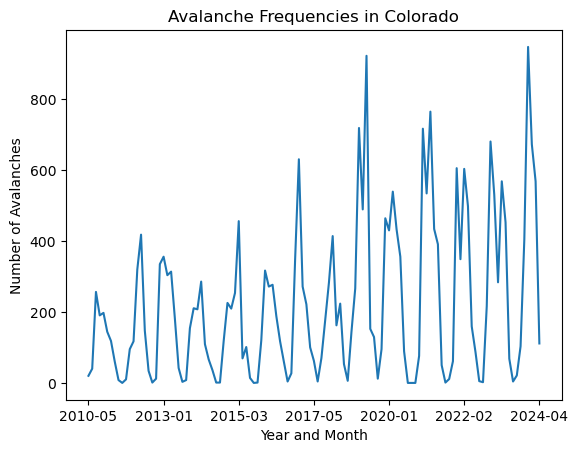

In [48]:
grouped_data = avalanches_data.groupby('year_month')
grouped_data.size().plot()

plt.xlabel('Year and Month')
plt.ylabel('Number of Avalanches')
plt.title('Avalanche Frequencies in Colorado');

In this visualization, we see a periodic trend where every year there is a drop off in avlanche frequencies that is explained by the warmer summer months. However, we can see that over these last 14 years, the general trend in the number of avalanche occurrences has slowly risen. This could be due to a number of factors — risinng global temperatures, changing weather patterns,an increase in artifically triggered avalanches, or simply more avalanche reporting are all possibilities. 

In terms of natural phenomena, we would like to determine if there is any correlation between the geographic features that influence avalanches and the changing climate. By understanding what is contributing to the rise in avalanches we will be able to provide outdoor enthusiasts and travelers with the adequate information they need to stay safe. Additionally, we may find evidence to further support and bolster the claims for climate change and the physcial impact it has on the Earth.

#### Avalance Frequencies Throughout the Year

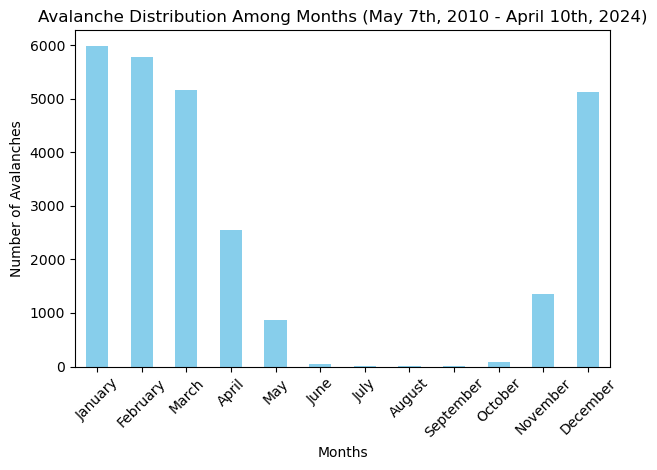

In [49]:
# Months should be in the order of the calendar year
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
avalanches_data['month'] = pd.Categorical(avalanches_data['month'], categories=month_order, ordered=True)

# Count the number of avalanches from each month over last 14 years
avalanche_counts = avalanches_data['month'].value_counts()
avalanche_counts = avalanche_counts.sort_index()

# Plot the Data
avalanche_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Months')
plt.ylabel('Number of Avalanches')
plt.title('Avalanche Distribution Among Months (May 7th, 2010 - April 10th, 2024)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The distribution of avalanches for each month from May 7th, 2010, to April 10th, 2024, shows that avalanches are most clustered in December through March, with a sharp drop in April. Obviously, there will be more avalanches during the colder, snowier months, but it is also possible that changing temperatures have influenced the number of avalanches within these cold months. Meaning that there could be fewer avalnches in March and April due to rising temperatures.

## Naturally Triggered vs Artificially Triggered Avalanches

This section was completed by Jackson Patrick

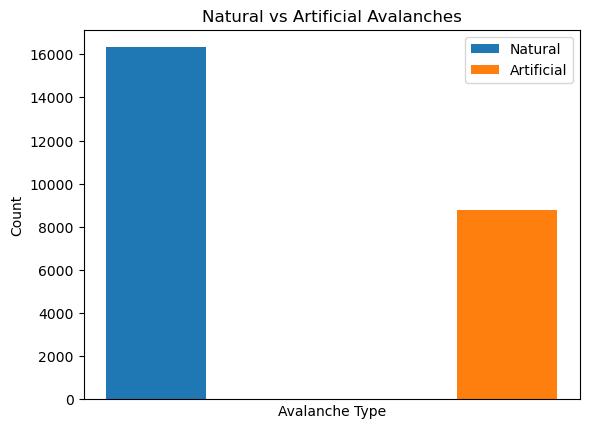

In [50]:
# Extract naturally and artificially triggered avalanches separately 
natural_data = avalanches_data.loc[avalanches_data['Trig'] == 'Natural', 'Trig']
artificial_data = avalanches_data.loc[avalanches_data['Trig'] == 'Artificial', 'Trig']

# Plot these frequencies
plt.hist([natural_data, artificial_data], bins=2, label=['Natural', 'Artificial'])
plt.xlabel('Avalanche Type')
plt.ylabel('Count')
plt.title('Natural vs Artificial Avalanches')
plt.legend()
plt.show()

Artifically triggered avalanches can refer to avalanches triggered by skiers or other recreationalists, but it can also include avalanches triggered pruposefuly. This is a technique used to prevent natural avalanches from killing travelers or blocked mountain roads. It is possible that this technique is used more often in high risk and high traffic areas due to the elevated danger of the area. Mountain roads can be dangerous for many reasons, but they are essentail to daily travel for many individuals. That being said, new roads could be popping up in different areas causing a heightened need for artifically triggering avalanches. 

## Comparing Avalanche Frequencies for Different Geographic Features

This section was completed by Trevor Chartier

#### Elevation

In [51]:
# Count frequencies for each elevation type (Relative to Tree Line)
elevations = pd.DataFrame(avalanches_data.groupby("Elev")['Asp'].count()).sort_values(by='Asp')

# Rename frequency column to be descriptive of content
elevations = elevations.rename(columns={"Asp": "Frequency"})

# We don't want frequencies for avalanches with All, Unknown, or Missing Values for elevations. Filter them out.                  
elevations = elevations.loc[(" <TL"," TL", " >TL"),:]

# Provide descriptive names for indexes
elevations.index = ["Below Tree Line", "Tree Line", "Above Tree Line"]

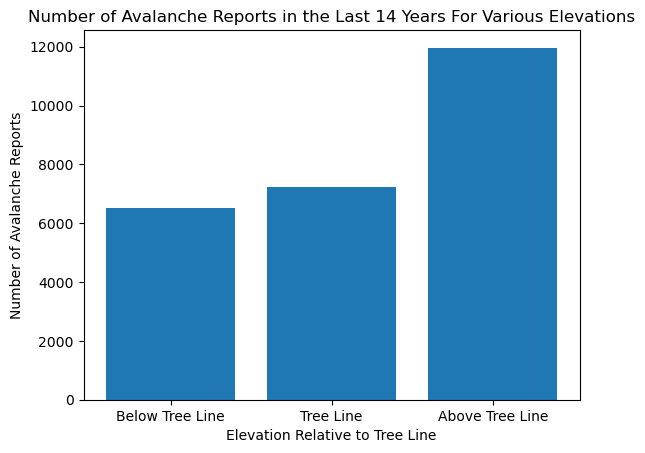

In [52]:
# Create barplot of elevation frequencies
plt.bar(elevations.index, elevations['Frequency'])
plt.xlabel('Elevation Relative to Tree Line')
plt.ylabel('Number of Avalanche Reports')
plt.title('Number of Avalanche Reports in the Last 14 Years For Various Elevations');


From the plot, it is clear that the avlanche frequency is increasing with elevation; this follows the expected trends. Higher elevations see more snowfall, and above tree line there is more exposure to the sun, wind, and nothing to help hold the snow in place. These are all factors that correlate with the shown increase in slide frequencies.

#### Slope Aspect

Slope aspect refers to the direction in which the slope faces. You have probably heard about the brand "The North Face"
This company name refers to the face of the slope that receives the least amount of sunlight. How will the direction in which the slope faces impact avalanche danger?

##### Prepare data for our visualization

In [53]:
# Count number of avalanche reports for each slope aspect
aspects = pd.DataFrame(avalanches_data.groupby("Asp")['Elev'].count())

# Rename frequency column to be more descriptive
aspects = aspects.rename(columns={"Elev": "Frequency"}) 

# We don't care about frequencies for the avalanches wit unknown or missing slope aspects. Filter them out.
aspects = aspects.loc[(" SW"," S"," W"," NW"," SE"," N"," NE"," E"),:]   

# Arrange the frequencies in their natural order according to compass direction
order = [" N", " NE", " E", " SE", " S", " SW", " W", " NW"] 
aspects = aspects.reindex(order)
aspects

Frequency
Asp           
 N        3872
 NE       5601
 E        6879
 SE       3685
 S        1381
 SW        832
 W        1701
 NW       1774

##### Now, we can create the figure

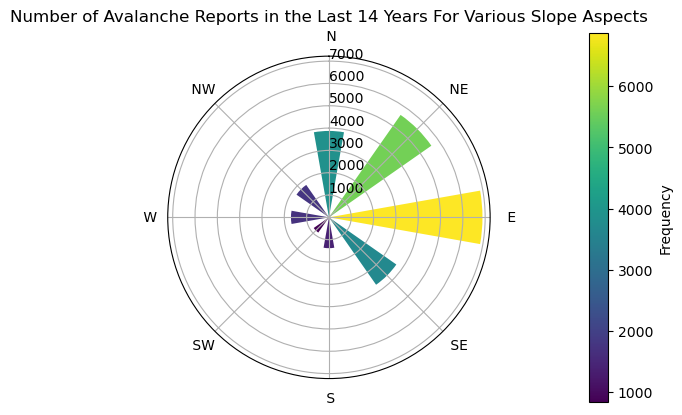

In [54]:
angles = np.radians(np.arange(0, 360, 45))  # 8 directions evenly spaced
frequencies = aspects['Frequency'].tolist()

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_direction(-1)  # Counter-clockwise direction
ax.set_theta_offset(np.pi/2)  # Start angle at 90 degrees (North)

# For coloring the bars based on frequencies
cmap = plt.colormaps['viridis'] 
norm = plt.Normalize(min(frequencies), max(frequencies))

# Plot the frequencies on the polar plot
bars = ax.bar(angles, frequencies, width=0.35, bottom=0, color=cmap(norm(frequencies)))


# Set the labels for each direction
ax.set_xticks(angles)
ax.set_xticklabels(aspects.index)

ax.set_rlabel_position(0)


# Set Title
ax.set_title("Number of Avalanche Reports in the Last 14 Years For Various Slope Aspects")

# Color bar legend
colorMap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
colBar = plt.colorbar(colorMap, ax=ax, pad=0.2)
colBar.set_label('Frequency')

# Show the polar plot
plt.show()

The results of this analysis were somewhat suprising. Personally, I had expected the Northern facing slopes to have the greatest frequency of avalanches because the lack of sunlight on this slope leads to greater snowpack retention. This is likely the reason that the sunnier Southern and South-West facing slopes have relatively few avalanches, but what makes the Eastern facing slopes so avlanche prone?

After some research, we found that this pattern can be explained by wind patterns. In Colorado, the prevailing winds typically travel from West to East. This makes the Eastern slopes the leeward slopes (the slopes oriented away from the wind). These eastern leeward slopes are succeptible to becoming wind loaded as snow blows onto them from the Western, windward slopes. This windloading is what makes them especially dangerous for avalanches.

To test this theory against our data, we should expect Eastern slopes to have a greater proportion of Cornice type avalanches as these formations are impacted by wind...

## Comparing Avalanche Types on Eastern and Western Slopes
This section was completed by Trevor Chartier

In order to see what is causing the great disparity in avalanche frequencies between Eastern and Western slopes, I have chosen to isolate Eastern and Western slope aspects and investigate the distribution of avalanche types for each aspect.

#### Prepare Data

In [55]:
def calcPrecentageWest(type):
    return len(type)/len(western_slope) * 100

def calcPercentageEast(type):
    return len(type)/len(eastern_slope) * 100

western_slope = avalanches_data[avalanches_data['Asp'] == ' W'] # Only avalanches with Western aspect
eastern_slope = avalanches_data[avalanches_data['Asp'] == ' E'] # Only avalances with Eastern aspect

# Calculate percentage of avalanches for each type for western slope
west = pd.DataFrame(western_slope.groupby('Type').apply(calcPrecentageWest))

# Avalanche code abbreviations can be found here: https://www.americanavalancheassociation.org/swag 
west.index = ['Cornice','Glide','Hard Slab','Loose','Roof', 'Soft Slab', 'Unknown', 'Wet-Loose','Wet Slab']
west.columns = ['Western']

# Repeat for Eastern Slope
east = pd.DataFrame(eastern_slope.groupby('Type').apply(calcPercentageEast))
east.index = ['Cornice','Glide','Hard Slab','Loose', 'Roof', 'Slush Flow', 'Soft Slab', 'Unknown', 'Wet-Loose','Wet Slab']
east.columns= ['Eastern']

# Merge into one dataframe
avalancheTypePercentage = pd.merge(east, west,left_index=True, right_index=True, how='outer')
avalancheTypePercentage.fillna(0, inplace=True)

avalancheTypePercentage

Eastern    Western
Cornice      1.306720   0.057670
Glide        0.186674   0.115340
Hard Slab   15.939115  11.649366
Loose        4.092476   5.190311
Roof         0.014360   0.115340
Slush Flow   0.014360   0.000000
Soft Slab   58.242389  54.671280
Unknown      2.527283   1.499423
Wet Slab     3.403217   8.650519
Wet-Loose    7.021827  13.610150

#### Plot Data

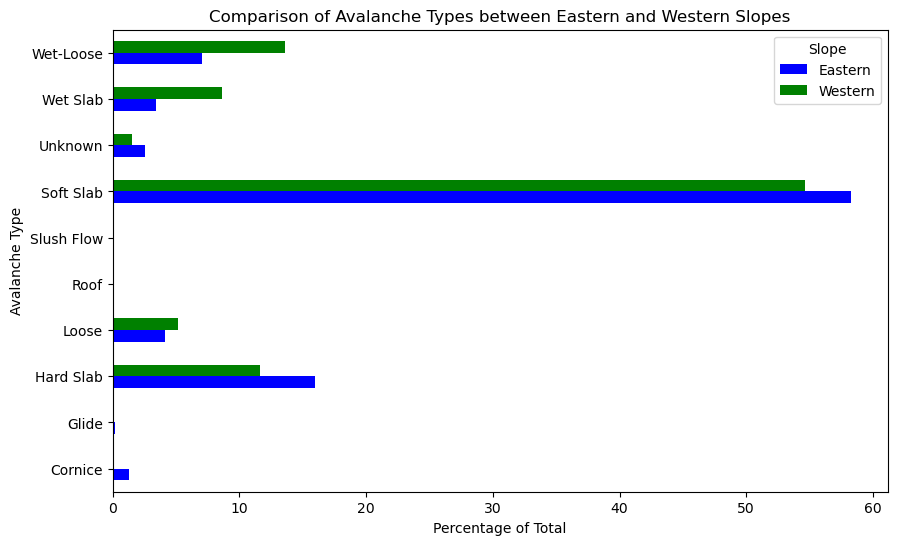

In [56]:
ax = avalancheTypePercentage.plot(kind='barh', figsize=(10, 6), color=['blue', 'green'])
ax.set_xlabel('Percentage of Total')
ax.set_ylabel('Avalanche Type')
ax.set_title('Comparison of Avalanche Types between Eastern and Western Slopes')
plt.legend(title='Slope', labels=['Eastern', 'Western'])
plt.show()

It should be made explicit that the x-axis is a measurement of the percentage of the total avalanches for the given slope aspect, NOT the total number of avalanches. 

As we expected, Cornice avalanches make up over a 22 times greater percentage of the total avalanches on Eastern slopes (1.3%) than they do on Western slopes (.058%). However, from the figure, we see that cornice avalances still make up a relatively small portion of total avalanches.

Although this visualization only shows East and West slope aspects for ease of direct comparison, it still provides us some interesting insight on the distribution of different avalanche types with soft slabs being by far the most common. In case your interested, an example of this avalanche type can be seen here: https://www.youtube.com/watch?v=yjDoE3trvOM 

## Investigating Avalanche Spatial Distributions Across the State of Colorado

This section was completed by Trevor Chartier

#### Preparing Data

In [57]:
# Each point will also include information on size, aspect, trigger, and elevation when hovered over
# We only want to plot points that have all of this information
map_avalanche_data = avalanches_data.dropna(subset = ['sizeD','Asp','Elev','Trig'])


# Remove Entries With Unknown Destructive Size
validCodes = [' D1',' D2',' D1.5',' D3.5',' D3',' D4',' D5']
mask = map_avalanche_data['sizeD'].isin(validCodes)
map_avalanche_data = map_avalanche_data[mask]

# Extract Destructive Sizes Into Numeric Column
map_avalanche_data['Destructive Size'] = map_avalanche_data['sizeD'].str[2:].astype(float)

In [58]:
# Define a custom color scale
custom_color_scale = [
    (0.0, 'rgb(15, 4, 135)'),    # Dark blue
    (0.05, 'rgb(63, 13, 207)'),
    (0.1, 'rgb(100, 21, 255)'),
    (0.15, 'rgb(136, 35, 255)'), # Purplish
    (0.20, 'rgb(170, 58, 252)'),
    (0.25, 'rgb(200, 18, 240)'),
    (0.35, 'rgb(190, 18, 190)'),
    (0.50, 'rgb(239, 100, 100)'),
    (0.68, 'rgb(242, 82, 24)'),  # Orange towards the higher end
    (0.80, 'rgb(253, 200, 8)'),
    (1.0, 'rgb(255, 255, 0)')      # Bright yellow
]

Points representing avalanche reports will be colored based on their size. There are far more D1 - D3 Avalanches than the extremely large D4-D5 avlanches. By defining a custom color scale, I am able to make the differences in color between the more common
D1-D3 avalanches more easy to dstinguish than by using a uniform color distribution. Additionally, I can take care
to avoid common accessibility issues with regards to colorblindness, such as red and green.


#### Plot Data

In [59]:
# Plot Avalanche reports over a map
# Size and color of points is dependent on avalanche size
fig = px.scatter_mapbox(map_avalanche_data, 
                        lat="latitude", 
                        lon="Longitude", 
                        color="Destructive Size", # Color of point is mapped based on avalanche size
                        hover_name= "sizeD",
                        hover_data= {"Trig":True,"Asp":True,"Elev":True,"sizeD":False,"latitude": False,
                                     "Longitude":False,'Destructive Size':False}, # What data appears when point is hovered over
                        size ="Destructive Size", # Size of point is proportional to avalanche size
                        size_max = 12,
                        zoom=8,
                        mapbox_style="open-street-map",
                        height=800,
                        width=800,
                        color_continuous_scale=custom_color_scale,
                        opacity= 0.5)

# Customize margins of figure
fig.update_layout(margin={"r":0,"t":20,"l":0,"b":0})
fig.show()

Destructive size ranges from 1 to 5 with 1 being relatively harmless and 5 being the largest avalanches known. 

Looking at the map, we see a prevelance of avalanches throughout the Rocky Mountain Range in CO. What could be the cause of the high avalance frequencies in these reigions? Lets investigate this and the increasing number of avalanches over time further by looking at weather patterns...

# SNOTEL Data Analysis
This section was completed by Aaron Graff

## Introduction

For the weather portion of our project, I generated a report of seven different SNOTEL stations, spread throughout the state of Colorado: Berthoud Pass Summit, Copper Mountain, Lake Irene, Rabbit Ears, Vail Mountain, Saint Elmo Ghost Town, and Spud Mountain (source of the Rio Grande River).  These stations have collected daily data on snowpack, air temperature, accumulation, and many other measurements relating to climate, for several decades.  After choosing these stations, I generated a report on only a few of these statistics: **Snow-Water Equivalent as a percentage of the average (1971-2020)**, **snow depth** (in inches), **air temperature** (in degrees Fahrenheit), and **precipitation accumulation** (in inches).  I chose the period of this data to be from April 2010 to April 2024, with monthly intervals in each value for each station, to align with the data range for our avalanche data.  Hopefully, this data will allow us to interpret some of the hotspots in Avalanche reports during this time, and analyze what changes are happening in our recent climate that might be impacting frequency (and severity) of avalanches.

## Load Data

First, we load the data in from a local file in my computer drive.  However, this exact report can be regenerated from this link: https://wcc.sc.egov.usda.gov/reportGenerator/.  I set the index to be the date because the default was just an index by row.

In [60]:
weather = pd.read_csv('CO_Snotel_Data.txt',
                      names = ['Date', 'Station ID', 'Station Name',
                               'Snow-Water Percent of Avg', 'Snow Depth', 'Air Temp', 'Precip Accumulation'])
weather.head()

Date  Station ID     Station Name  Snow-Water Percent of Avg  \
0  Apr 2010         335  Berthoud Summit                       96.0   
1  May 2010         335  Berthoud Summit                      101.0   
2  Jun 2010         335  Berthoud Summit                       68.0   
3  Jul 2010         335  Berthoud Summit                        0.0   
4  Aug 2010         335  Berthoud Summit                        NaN   

   Snow Depth  Air Temp  Precip Accumulation  
0        56.0      29.7                 19.5  
1        67.0      10.0                 26.9  
2        23.0      39.2                 30.7  
3         0.0      49.5                 33.2  
4         0.0      48.9                 35.6

Additionally, here is a list of all seven stations with their corresponding elevations for reference (in descending order):                             
**Berthoud Summit**: 11,314 ft.                                             
**Lake Irene**: 10,682 ft.                                        
**Spud Mountain**: 10,674 ft.                                    
**Copper Mountain**: 10,523 ft.                                  
**Saint Elmo**: 10,450 ft.                                  
**Vail Mountain**: 10,310 ft.                                 
**Rabbit Ears Pass**: 9,411 ft.

## Map of Stations

To better visualize the location of these seven stations, I will map them out based on their exact latitude and longitude, as listed on the USDA Website.  The first step in doing so is to add those latitude and longitude values in a seperate dataframe for each station.  Then, we will map these points to illustrate their locations in the Colorado mountains.

In [61]:
lat = [39.8, 39.49, 40.41, 40.37, 38.7, 37.7, 39.62]
longitude = [-105.78, -106.17, -105.82, -106.74, -106.37, -107.78, -106.38]
stations = ['Berthoud Summit', 'Copper Mountain', 'Lake Irene', 'Rabbit Ears',
            'Saint Elmo', 'Spud Mountain', 'Vail Mountain']
coordinates_dict = {'Stations': stations, 'Latitude': lat, 'Longitude': longitude}
locations = pd.DataFrame(coordinates_dict)
locations

Stations  Latitude  Longitude
0  Berthoud Summit     39.80    -105.78
1  Copper Mountain     39.49    -106.17
2       Lake Irene     40.41    -105.82
3      Rabbit Ears     40.37    -106.74
4       Saint Elmo     38.70    -106.37
5    Spud Mountain     37.70    -107.78
6    Vail Mountain     39.62    -106.38

In [62]:
import plotly.express as px

snotel_map = px.scatter_mapbox(locations, lat = 'Latitude', lon = 'Longitude',
                               hover_name = 'Stations',
                               mapbox_style = 'open-street-map',
                               height = 800, width = 800)

snotel_map.show()

## Data Cleaning

Now, let's clean the data by replacing all NaN values with zeros for each column of data:

In [63]:
weather['Snow-Water Percent of Avg'] = weather['Snow-Water Percent of Avg'].replace(np.nan, 0)
weather['Snow Depth'] = weather['Snow Depth'].replace(np.nan, 0)
weather['Air Temp'] = weather['Air Temp'].replace(np.nan, 0)
weather['Precip Accumulation'] = weather['Precip Accumulation'].replace(np.nan, 0)

## Basic Descriptive Statistics

To start our analysis, let's generate some basic sample statistics to compare each station over the last 14 years.

#### Snow Depth Mean and Standard Deviation

In [64]:
weather.groupby('Station Name')['Snow Depth'].mean()

Station Name
Berthoud Summit    25.781065
Copper Mountain    19.177515
Lake Irene         31.355030
Rabbit Ears        26.568047
Saint Elmo         13.905325
Spud Mountain      24.544379
Vail Mountain      19.041420
Name: Snow Depth, dtype: float64

In [65]:
weather.groupby('Station Name')['Snow Depth'].std()

Station Name
Berthoud Summit    25.700067
Copper Mountain    20.579502
Lake Irene         31.608157
Rabbit Ears        29.542490
Saint Elmo         15.543427
Spud Mountain      30.118804
Vail Mountain      21.423273
Name: Snow Depth, dtype: float64

#### Air Temperature Mean and Standard Deviation

In [66]:
weather.groupby('Station Name')['Air Temp'].mean()

Station Name
Berthoud Summit    26.350296
Copper Mountain    27.796450
Lake Irene         28.072781
Rabbit Ears        32.791716
Saint Elmo         29.459763
Spud Mountain      33.264497
Vail Mountain      33.638462
Name: Air Temp, dtype: float64

In [67]:
weather.groupby('Station Name')['Air Temp'].std()

Station Name
Berthoud Summit    15.846012
Copper Mountain    14.261962
Lake Irene         13.945001
Rabbit Ears        15.215865
Saint Elmo         13.432478
Spud Mountain      13.837606
Vail Mountain      14.663800
Name: Air Temp, dtype: float64

#### Precipitation Accumulation Mean and Standard Deviaton

In [68]:
weather.groupby('Station Name')['Precip Accumulation'].mean()

Station Name
Berthoud Summit    20.462130
Copper Mountain    13.894675
Lake Irene         19.069231
Rabbit Ears        24.194675
Saint Elmo         11.321302
Spud Mountain      21.437870
Vail Mountain      14.790533
Name: Precip Accumulation, dtype: float64

In [69]:
weather.groupby('Station Name')['Precip Accumulation'].std()

Station Name
Berthoud Summit    13.500321
Copper Mountain     9.310703
Lake Irene         12.723516
Rabbit Ears        15.737543
Saint Elmo          7.665889
Spud Mountain      15.116488
Vail Mountain       9.956155
Name: Precip Accumulation, dtype: float64

Generally speaking, all of these SNOTEL station locations are with 2,000 feet in elevation (with 5 out of 7 being in the 10,000 to 11,000 ft. range).  The Rabbit Ears Pass station has the lowest elevation out of these seven, sitting at 9,411 feet, while Berthoud Summit has the highest elevation (11,314 feet).  Thus, it makes sense that Berthoud Summit had the lowest average montly air temperature reported over the last 14 years.  Other than that, these stations had roughly similar averages during this time, so it will be more helpful in our analysis to dive deeper into these trends over time.

Another important trend is that standard deviation in precipitation accumulation and snow depth are quite high for all seven stations, something that could be contributing to more unstable mountain conditions (in terms of snow), leading to more avalanches.

## General Graphical Analysis

To begin, I think it would be helpful to be able to visualize each column of weather data over time for each station.  We will do this by separating the data by each station, and then plotting each statistic, starting with average snow water equivalent.

In [70]:
berthoud = weather[weather['Station Name'] == 'Berthoud Summit']
copper = weather[weather['Station Name'] == 'Copper Mountain']
lake_irene = weather[weather['Station Name'] == 'Lake Irene']
rabbit_ears = weather[weather['Station Name'] == 'Rabbit Ears']
saint_elmo = weather[weather['Station Name'] == 'Saint Elmo']
spud_mountain = weather[weather['Station Name'] == 'Spud Mountain']
vail = weather[weather['Station Name'] == 'Vail Mountain']

For each graph, I will focus on four stations: Saint Elmo, Berthoud Summit,  Rabbit Ears Pass, and Spud Mountain, to simplify each graph while still representing several different regions of the state.

#### Snow-Water Equivalency as an Percent Average

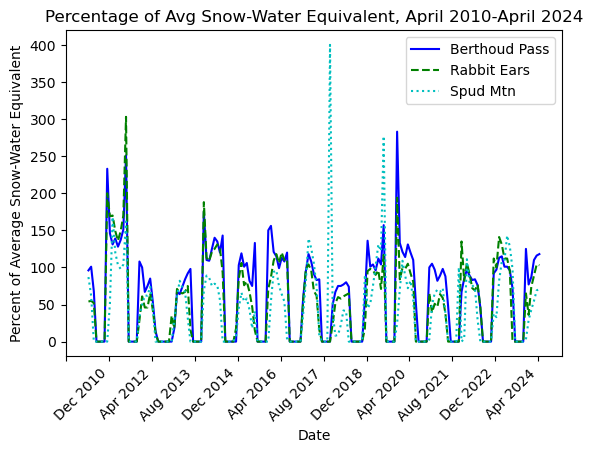

In [71]:
fig = plt.figure()
ax = fig.add_subplot()
berthoud_plot, = ax.plot(berthoud['Date'], berthoud['Snow-Water Percent of Avg'], '-b', label = 'Berthoud Pass')
rabbit_ears_plot, = ax.plot(rabbit_ears['Date'], rabbit_ears['Snow-Water Percent of Avg'], '--g', label = 'Rabbit Ears')
spud_plot, = ax.plot(spud_mountain['Date'], spud_mountain['Snow-Water Percent of Avg'], ':c', label = 'Spud Mtn')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 16))
ax.set_xlabel('Date')
ax.set_ylabel('Percent of Average Snow-Water Equivalent')
ax.set_title('Percentage of Avg Snow-Water Equivalent, April 2010-April 2024')
fig.autofmt_xdate(rotation=45)
ax.legend(handles = [berthoud_plot, rabbit_ears_plot, spud_plot])

For this plot, it is important to remember that this the y-variable is a percentage in relation to average snow-water equivalent for each of these three regions from 1971 to 2020.  According to the USDA website, snow-water equivalent can be described as the actual amount of water present, if it were all melted at once.  Being in the San Jaun Mountain range, it makes sense that Spud Mountain has very different trends in snow-water equivalent compared to the others, which are located farther northeast in the Rockies.  August through September of 2017 must have been a significant time for precipitation in that region, while Berthoud Summit and Rabbit Ears pass had similar peaks in abnormally high snow-water equivalency in 2019, and 2010-2011.  All snow-water equivalent measurements for the Saint Elmo ghost town were 0,  which can be attributed to a lack of data (earlier, I replaced NA values with 0, leading to these results for the Saint Elmo station).  Because of this, I removed Saint Elmo from the graph for this statistic.

#### Snow Depth Over Time

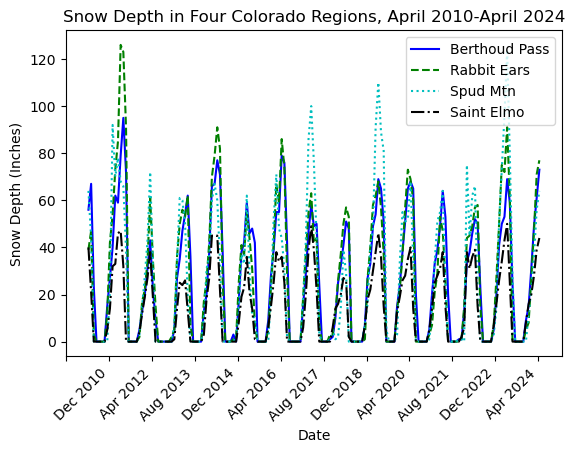

In [72]:
fig = plt.figure()
ax = fig.add_subplot()
berthoud_plot2, = ax.plot(berthoud['Date'], berthoud['Snow Depth'], '-b', label = 'Berthoud Pass')
rabbit_ears_plot2, = ax.plot(rabbit_ears['Date'], rabbit_ears['Snow Depth'], '--g', label = 'Rabbit Ears')
spud_plot2, = ax.plot(spud_mountain['Date'], spud_mountain['Snow Depth'], ':c', label = 'Spud Mtn')
saint_elmo_plot2, = ax.plot(saint_elmo['Date'], saint_elmo['Snow Depth'], '-.k', label = 'Saint Elmo')
fig.autofmt_xdate(rotation=45)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 16))
ax.set_xlabel('Date')
ax.set_ylabel('Snow Depth (Inches)')
ax.set_title('Snow Depth in Four Colorado Regions, April 2010-April 2024')
ax.legend(handles = [berthoud_plot2, rabbit_ears_plot2, spud_plot2, saint_elmo_plot2])

This measurement is a little more helpful for our analysis, because it records an actual value for each station, rather than an average.  We can see that most of the wetter winter seasons are correlated for each region of Colorado, as well as the dryer winters.  Winter of 2010-2011, 2013-2014, 2018-2019, and 2022-2023 were particularly more snowy in all four stations.  Another interesting observation is that the snowier winters for all four stations amounted to a much larger peak in snow depth in the Spud Mountain data, except for the 2010-2011 winter.  Winter of 2014-2015, 2017-2018, and 2020-2021 all tended to be drier winters for all four stations.  Additionally, regardless of the year, Saint Elmo ghost town almost always has the lowest peak in snow depth, despite its elevation of 10,450 feet (which is higher than both the Rabbit Ears Pass and Vail stations).

#### Air Temperature

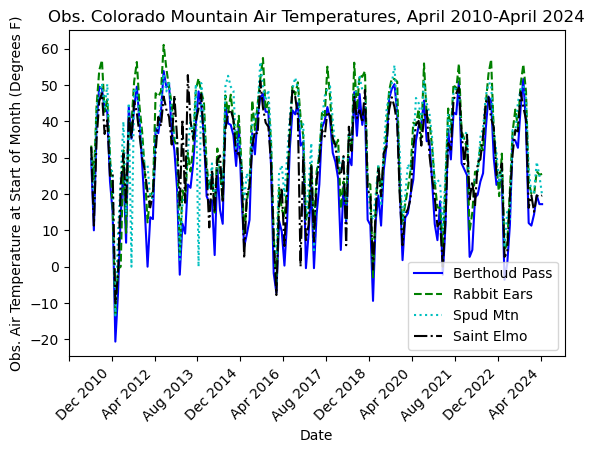

In [73]:
fig = plt.figure()
ax = fig.add_subplot()
berthoud_plot3, = ax.plot(berthoud['Date'], berthoud['Air Temp'], '-b', label = 'Berthoud Pass')
rabbit_ears_plot3, = ax.plot(rabbit_ears['Date'], rabbit_ears['Air Temp'], '--g', label = 'Rabbit Ears')
spud_plot3, = ax.plot(spud_mountain['Date'], spud_mountain['Air Temp'], ':c', label = 'Spud Mtn')
saint_elmo_plot3, = ax.plot(saint_elmo['Date'], saint_elmo['Air Temp'], '-.k', label = 'Saint Elmo')
fig.autofmt_xdate(rotation=45)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 16))
ax.set_xlabel('Date')
ax.set_ylabel('Obs. Air Temperature at Start of Month (Degrees F)')
ax.set_title('Obs. Colorado Mountain Air Temperatures, April 2010-April 2024')
ax.legend(handles = [berthoud_plot3, rabbit_ears_plot3, spud_plot3, saint_elmo_plot3])

Admittedly, this graph is a little bit more chaotic-looking, and that is mostly because the observed temperatures for these stations are fairly well-aligned over the years.  Rabbit Ears Pass consistently has a warmer maximum temperature than the other stations in the summer months, and Berthoud Summit consistently gets colder during the extremes of the winter months, when compared to the other stations.  This makes sense because Rabbit Ears pass has the lowest elevation of these seven stations (less than 10,000 feet), while Berthoud Summit has the highest elevation (over 11,000 ft.).  Looking at each station overall, it does seem like the minimum winter temperature in each year is increasing ever so slightly in recent years, although it's difficult to tell if this is just random variation or an overall trend that will continue into the future.

#### Precipitation Accumulation

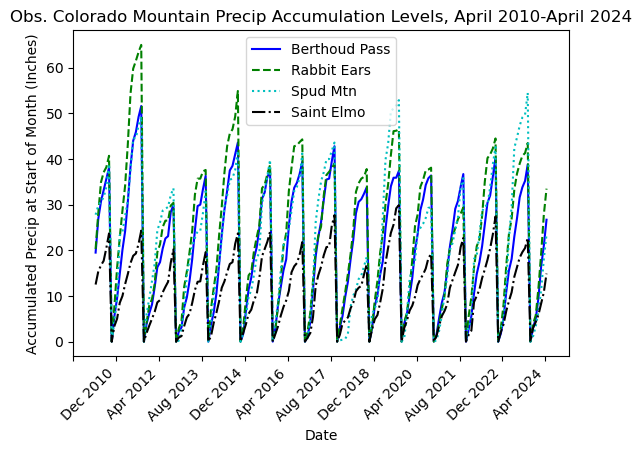

In [74]:
fig = plt.figure()
ax = fig.add_subplot()
berthoud_plot4, = ax.plot(berthoud['Date'], berthoud['Precip Accumulation'], '-b', label = 'Berthoud Pass')
rabbit_ears_plot4, = ax.plot(rabbit_ears['Date'], rabbit_ears['Precip Accumulation'], '--g', label = 'Rabbit Ears')
spud_plot4, = ax.plot(spud_mountain['Date'], spud_mountain['Precip Accumulation'], ':c', label = 'Spud Mtn')
saint_elmo_plot4, = ax.plot(saint_elmo['Date'], saint_elmo['Precip Accumulation'], '-.k', label = 'Saint Elmo')
fig.autofmt_xdate(rotation=45)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 16))
ax.set_xlabel('Date')
ax.set_ylabel('Accumulated Precip at Start of Month (Inches)')
ax.set_title('Obs. Colorado Mountain Precip Accumulation Levels, April 2010-April 2024')
ax.legend(handles = [berthoud_plot4, rabbit_ears_plot4, spud_plot4, saint_elmo_plot4])

SNOTEL stations collect precipitation accumulation throughout the year (adding it up each month), and then reset the value at the beginning of October in each year, which is why this graph has a consistent, sharp drop off each year.  Still, we can use this graph to observe some of the patterns we saw in the snow depth and snow-water equivalent data: very wet years in 2011, 2014, 2019, and 2023, compared to overall drier years in 2012-2013 and 2017-2018.  Another interesting pattern is the level of variation in accumulated precipitation.  Saint Elmo seems to vary pretty significantly in yearly accumulated precipitation.  Take, for example, the peak in September of 2019, which is close to 30 inches of precipitation for the last 12 months.  A year later, the total accumulation was not even 20 inches, meaning there was a difference of at least 10 inches of precipitation from year to year.  Similary, Rabbit Ears Pass has wide fluctuations in yearly precipitation.  Around September of 2014, Rabbit Ears Pass accumulated around 55 inches of precipitation since September of the previous year.  A year later, it had a little bit less than 40 inches.  Contrary to the trend with avalanche data, Berthoud Summit actually seemed to be the most consistent in yearly precipitation, other than from September of 2011 to September of 2012.

# Conclusion and Connection to Avalanche Data

Overall, I think this SNOTEL data has shown some interesting patterns in how Colorado climate is changing.  Specifically when it comes to snow depth and precipitation accumulation, there are significant fluctuations from year to year, which no doubt have an impact on severity and frequency of avalanches.  Even more significantly, in my opinion, is the evidence relating to air temperature.  In the last 14 years, the overall minimum winter temperature in these four stations seems to be increasing (on average).  This could potentially contribute to less stable snow conditions the Colorado mountains, creating more favorable circumstances for avalanches to occur.

Of course, it is important to note that the data being analyzed here is monthly for only the last 14 years.  What this data does not take into account is how conditions are changing daily or even by the hour.  This is an important distinction, because conditions on a mountain peak can vary drastically even within a few hours, which is a level of change that can cause an avalanche in an instant.

Regardless, the main takeaway from this data is that variations in weather from year to year are increasing over time.  As proven by the fluctations in peaks and valleys for the four stations graphed with each statistic, extremely cold or snowy winters are often followed up with very mild and/or dry winters soon after.  Additionally, the standard deviations for precipitation accumulation and snow depth are quite large, with many of the snow depth standard deviations being larger than the means themselves.  In general, conditions that favor more frequent and severe avalanche danger tend to be more unstable (especially concerning snow depth, snow melt, and air temperature).  Even this small subset of data indicates that weather is becoming less and less predictable in the Colorado mountains from month to month.  As the earth's climate continues to change into the future, this unpredictability in weather will likely only increase, not only on a monthly basis, but also on a daily and hourly one.  In the end, only time will tell as to whether or not the current trend of increased natural avalanches in recent years continues in correspondence with more unpredictable mountain weather.